## 1. Import Required Libraries

In [1]:

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Evaluation metrics
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score


## 2. Load and Inspect Dataset


In [2]:

# Load the dataset
df = pd.read_csv("online_shoppers_intention.csv")

# Preview the dataset
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
# Dataset structure and missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
df.isnull().sum()


,0
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0
SpecialDay,0


## 3. Feature Engineering and Data Transformation


In [5]:

# Log transform to reduce skewness

df["PageValues_log"] = np.log1p(df["PageValues"])

# Convert month names to numeric values

month_map= {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6,
             'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
df["Month"]=df["Month"].map(month_map)

# Binary encoding

df["VisitorType"]=df["VisitorType"].apply(lambda x:1 if x=="Returning_Visitor" else 0)
df["Weekend"]=df["Weekend"].apply(lambda x:1 if x==True else 0)
df["Revenue"]=df["Revenue"].apply(lambda x:1 if x==True else 0)

In [6]:
df=pd.get_dummies(df, columns=["TrafficType","Region","Browser","OperatingSystems"],drop_first=True)

In [7]:

# Aggregate page views and durations

df["TotalPageViews"]=df["Administrative"] + df["Informational"]+ df["ProductRelated"]

df["TotalDuration"]=df["Administrative_Duration"] + df["Informational_Duration"] + df["ProductRelated_Duration"]

# Indicator for valuable pages

df["IsHighPageValue"]=df["PageValues"].apply(lambda x:1 if x>0 else 0)

## 4. Feature Scaling


In [8]:
scaler=StandardScaler()

scale_cols=['Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'TotalDuration']

df[scale_cols] = scaler.fit_transform(df[scale_cols])

## 5. Customer Segmentation using K-Means


In [9]:

# Clustering based on engagement behavior

cluster=KMeans(n_clusters=2,random_state=42)

df["cluster"]=cluster.fit_predict(df[scale_cols])

## 6. Train-Test Split


In [10]:
# Separate features and target

X=df.drop("Revenue",axis=1)

y=df["Revenue"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=101,stratify=y)

## 7. Model Training


In [11]:
# Initialize Random Forest with class balancing

classifier=RandomForestClassifier(n_estimators=300,max_depth=15,class_weight="balanced",random_state=42)

# Train the model

classifier.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=300,
                       random_state=42)

## 8. Model Evaluation


In [12]:
# Predictions

y_train_pred=classifier.predict(X_train)

y_pred=classifier.predict(X_test)

y_prob=classifier.predict_proba(X_test)[:,1]

In [13]:
# Compute evaluation metrics

classifier_train_accuracy=accuracy_score(y_train,y_train_pred)

classifier_test_accuracy=accuracy_score(y_test,y_pred)

classifier_precision=precision_score(y_test,y_pred,pos_label=1)

classifier_recall=recall_score(y_test,y_pred)

classifier_f1=f1_score(y_test,y_pred)

classifier_roc_auc=roc_auc_score(y_test,y_prob)

metrics = {
    'Metric': ['Train Accuracy','Test Accuracy','Precision','Recall','F1 Score','ROC-AUC'],
    'Score': [classifier_train_accuracy, classifier_test_accuracy, classifier_precision,
              classifier_recall, classifier_f1, classifier_roc_auc,] }

metrics_df=pd.DataFrame(metrics)

print(metrics_df)


           Metric     Score
0  Train Accuracy  0.971498
1   Test Accuracy  0.892944
2       Precision  0.634969
3          Recall  0.723776
4        F1 Score  0.676471
5         ROC-AUC  0.923907


## 9. Cluster Visualization using PCA


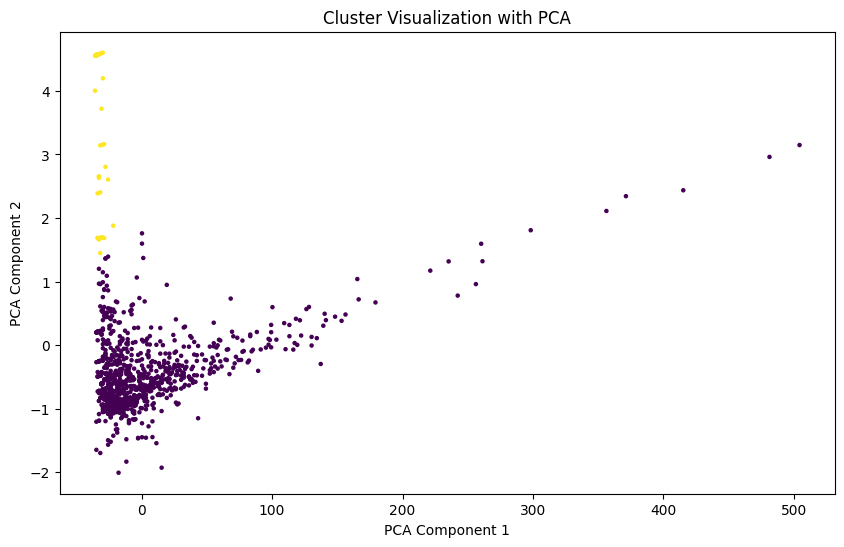

In [14]:
numeric_cols=['TotalPageViews','TotalDuration','BounceRates','ExitRates','PageValues']

sample=df.sample(1000,random_state=42)

pca=PCA(n_components=2)

components_sample=pca.fit_transform(sample[numeric_cols])

plt.figure(figsize=(10,6))
plt.scatter(components_sample[:,0],components_sample[:,1],c=sample["cluster"],cmap="viridis",s=5)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization with PCA")
plt.show()

## 10. Exploratory Data Analysis (EDA)


**10.1 Revenue Distribution**

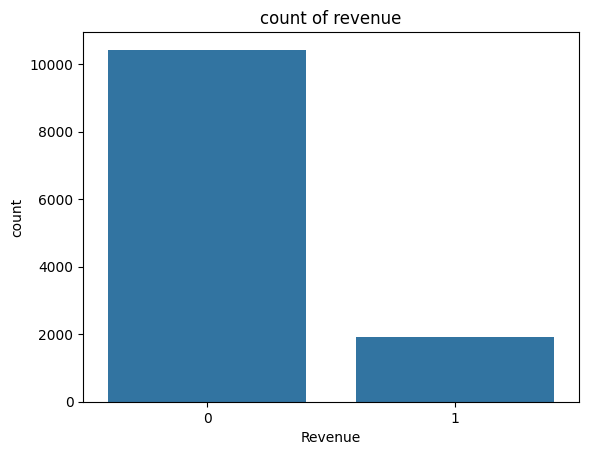

In [15]:
sns.countplot(x="Revenue",data=df)

plt.title("count of revenue")
plt.show()


**10.2 Purchase Ratio (Pie Chart)**

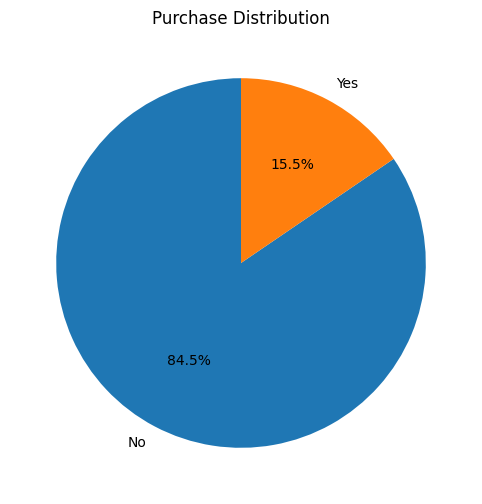

In [16]:
values=df["Revenue"].value_counts()
labels=["No","Yes"]

plt.figure(figsize=(10,6))
plt.pie(values,labels=labels,autopct="%1.1f%%",startangle=90)
plt.title("Purchase Distribution")
plt.show()

**10.3 Correlation Heatmap**

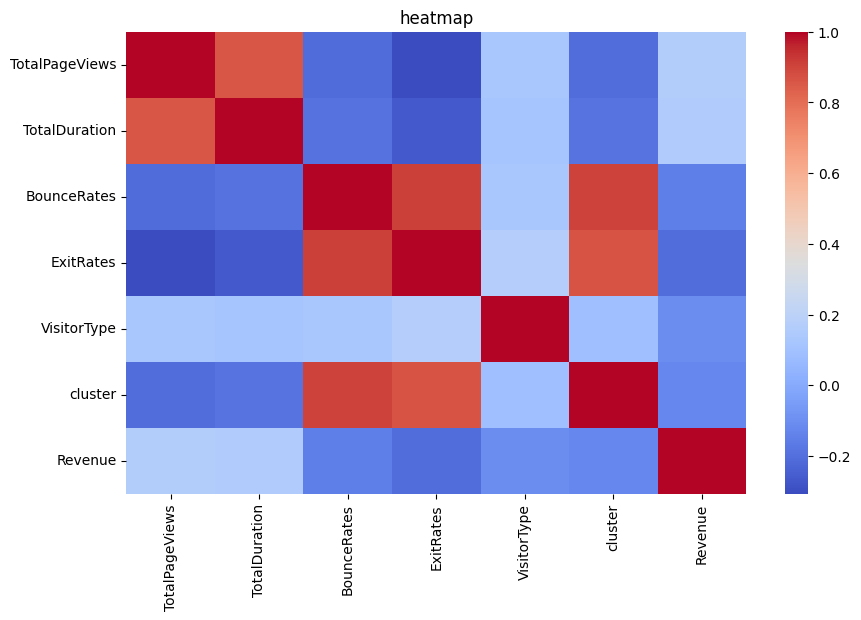

In [17]:
heatmap_cols = [
    "TotalPageViews",
    "TotalDuration",
    "BounceRates",
    "ExitRates",
    "VisitorType",
    "cluster",
    "Revenue"]

c=df[heatmap_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(c,cmap="coolwarm")
plt.title("heatmap")
plt.show()


## 11. Feature Importance Analysis


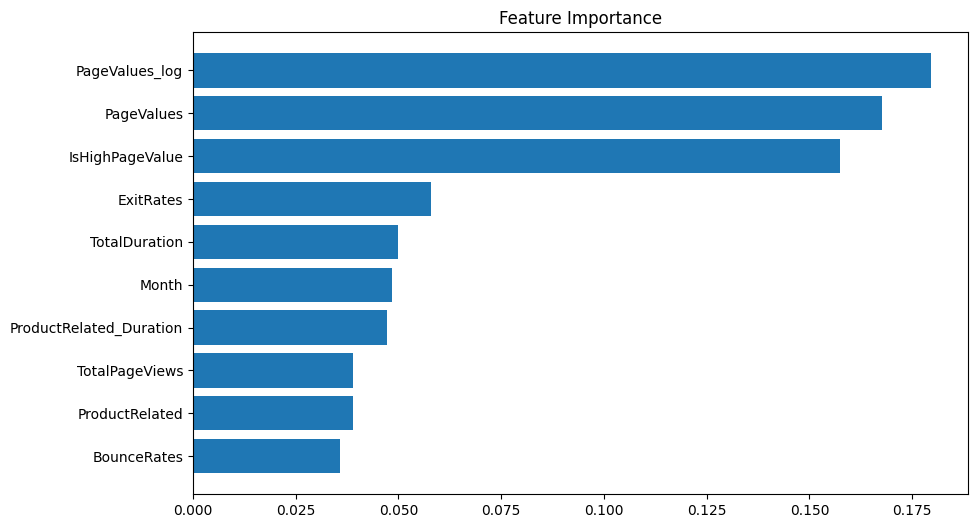

In [18]:
features=X.columns
importances=classifier.feature_importances_

feat_df=pd.DataFrame({"Feature":features , "Importance":importances})
feat_df=feat_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_df["Feature"][:10][::-1],feat_df["Importance"][:10][::-1])
plt.title("Feature Importance")
plt.show()

## 12. ROC Curve and Confusion Matrix


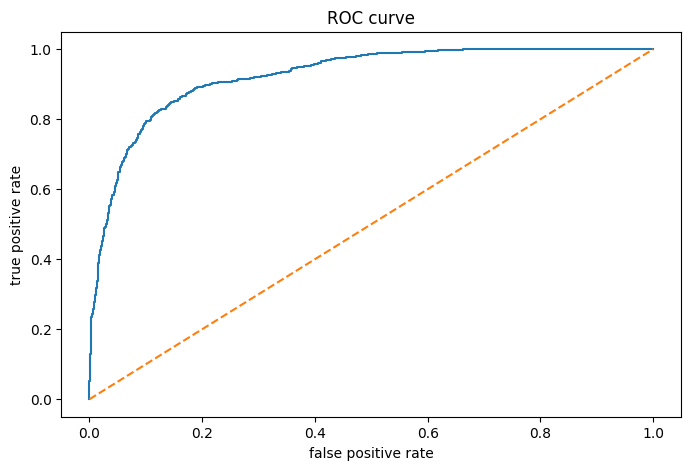

In [19]:
# ROC Curve

fpr,tpr,_=roc_curve(y_test,y_prob)

plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label=f"AUC = {classifier_roc_auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve")
plt.show()

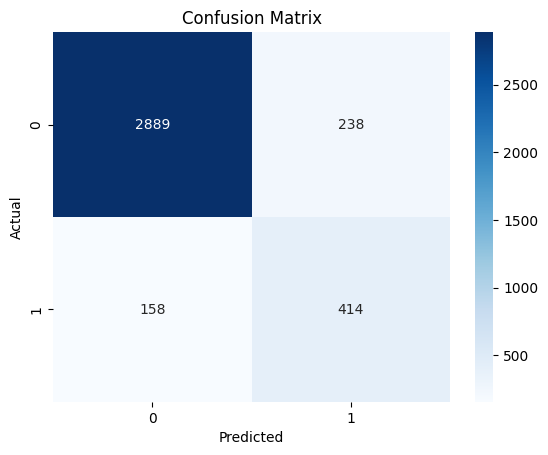

confusion matrix : [[2889  238]
 [ 158  414]]


In [20]:
# Confusion Matrix

cm=confusion_matrix(y_test,y_pred)

sns.heatmap(cm,fmt="d",cmap="Blues",annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


print("confusion matrix :",cm)